In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
X = pd.read_csv('data/X.csv', index_col = 0)
Y = pd.read_csv('data/Y.csv', index_col = 0)
feature_50 = pd.read_csv('data/feature_50.csv', index_col = 0)

In [3]:
X.shape

(37623199, 29)

In [4]:
full_df = pd.concat([X,Y], axis = 1)

In [5]:
full_df.shape

(37623199, 30)

In [6]:
joined_df = full_df.merge(feature_50, how = 'inner', on = 'srch_destination_id')

In [7]:
joined_df.columns

Index(['site_name', 'user_location_country', 'user_location_region',
       'user_location_city', 'is_package', 'channel', 'srch_adults_cnt',
       'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster',
       'imputed_distance', 'srch_before_ci', 'srch_trip_duration',
       'encoded_day_of_year_srch', 'srch_destination_type_id_0',
       'srch_destination_type_id_1', 'srch_destination_type_id_2',
       'srch_destination_type_id_3', 'srch_destination_type_id_4',
       'srch_destination_type_id_5', 'srch_destination_type_id_6',
       'srch_destination_type_id_7', 'srch_destination_type_id_8',
       'srch_destination_type_id_9', 'is_booking', 'd1', 'd2', 'd3', 'd4',
       'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15',
       'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25',
       'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35',
 

In [9]:
import gc

In [ ]:
del X
del Y
del full_df

In [11]:
gc.collect()

931

In [12]:
Y = joined_df.pop('is_booking')

In [13]:
joined_df.shape

(37456397, 79)

In [14]:
Y.shape

(37456397,)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
del feature_50

In [17]:
gc.collect()

0

In [18]:
X_train, X_test, y_train, y_test = train_test_split(joined_df, Y, 
                                                test_size = 0.2, 
                                                random_state = 42, 
                                                stratify = Y)

In [19]:
len(X_train.columns)

79

In [20]:
gc.collect()

0

In [21]:
len(y_train[y_train == 1])/len(y_train)

0.0797774959463699

In [22]:
len(y_test[y_test == 1])/len(y_test)

0.07977742121506605

<font size = 4>Do TargetEncoding for hotel_cluster. Fit the transformer on traning data. Note: hotel_cluster on training data will be target_encoded but hotel_cluster on testing data will not. Because we need to predict hotel_cluster on testing data, so we need to preserve the original hotel_cluster

In [23]:
from category_encoders import TargetEncoder

In [25]:
TE = TargetEncoder(cols = ['hotel_cluster']).fit(X_train.hotel_cluster, y_train)

our data is very imbalanced, so we do under sampling

In [26]:
from imblearn.under_sampling import RandomUnderSampler

In [27]:
rus = RandomUnderSampler(replacement = False, random_state = 42)

In [29]:
gc.collect()

2939

In [30]:
X_train_subsample, y_train_subsample = rus.fit_resample(X_train, y_train)

In [31]:
print("shape of train features:")
print(X_train_subsample.shape)
print(f'there are {y_train_subsample.value_counts()[1]} positive labels and {y_train_subsample.value_counts()[0]} negative labels')

shape of train features:
(4781084, 79)
there are 2390542 positive labels and 2390542 negative labels


In [32]:
del X_train
del y_train

In [33]:
gc.collect()

0

<font size = 4>Now transform the sample X using the transformer fitted on training data

In [36]:
X_train_subsample['hotel_cluster'] = TE.transform(X_train_subsample.hotel_cluster)

In [39]:
X_train_subsample.hotel_cluster

0          0.087344
1          0.051010
2          0.132750
3          0.074688
4          0.103300
             ...   
4781079    0.094985
4781080    0.067474
4781081    0.079560
4781082    0.115664
4781083    0.116076
Name: hotel_cluster, Length: 4781084, dtype: float64

In [ ]:
X_train_subsample.to_csv('X_train_subsample.csv')
y_train_subsample.to_csv('y_train_subsample.csv')

In [ ]:
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')

In [40]:
X_train_subsample.isnull().sum().sum()

0

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
X_train_subsample.hotel_cluster

0          0.087344
1          0.051010
2          0.132750
3          0.074688
4          0.103300
             ...   
4781079    0.094985
4781080    0.067474
4781081    0.079560
4781082    0.115664
4781083    0.116076
Name: hotel_cluster, Length: 4781084, dtype: float64

In [43]:
lr = LogisticRegression().fit(X_train_subsample,y_train_subsample)

In [44]:
lr.score(X_train_subsample,y_train_subsample)

0.5805507704947246

<font size = 4> hotel_cluster is not transformed in test data, because we need to predict them!

In [45]:
X_test.hotel_cluster

18334792    97
16762169    64
31848731    40
1037591     88
27288128    47
            ..
18463313    21
32405805    91
15353340    58
27387051    81
30980201    37
Name: hotel_cluster, Length: 7491280, dtype: int64

C:\Users\jy3178\.conda\envs\sklearn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


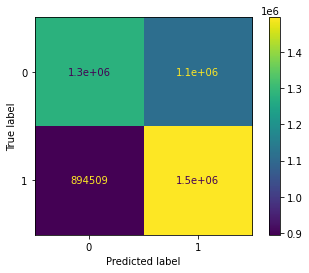

In [48]:
plot_confusion_matrix(lr, X_train_subsample, y_train_subsample)
plt.show()

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

In order to test the accuracy, we need to find the hotels that the user actually booked, i.e: is_booking == 1

In [49]:
test_df = pd.concat([X_test,y_test], axis = 1)

In [50]:
booked_df = test_df[test_df.is_booking == 1]

In [51]:
booked_df.is_booking.unique()

array([1], dtype=int64)

In [52]:
#since all of them are booked, we don't need is_booking anymore
booked_df.pop('is_booking')

2551576     1
25258460    1
21926657    1
33793896    1
34189250    1
           ..
5671470     1
6573088     1
26971676    1
16316081    1
35470461    1
Name: is_booking, Length: 597635, dtype: int64

In [53]:
cluster_index = X_test.columns.get_loc('hotel_cluster')

In [54]:
Y = booked_df.pop('hotel_cluster')
X = booked_df

In [55]:
X.shape

(597635, 78)

In [56]:
X.columns

Index(['site_name', 'user_location_country', 'user_location_region',
       'user_location_city', 'is_package', 'channel', 'srch_adults_cnt',
       'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market', 'imputed_distance',
       'srch_before_ci', 'srch_trip_duration', 'encoded_day_of_year_srch',
       'srch_destination_type_id_0', 'srch_destination_type_id_1',
       'srch_destination_type_id_2', 'srch_destination_type_id_3',
       'srch_destination_type_id_4', 'srch_destination_type_id_5',
       'srch_destination_type_id_6', 'srch_destination_type_id_7',
       'srch_destination_type_id_8', 'srch_destination_type_id_9', 'd1', 'd2',
       'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13',
       'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23',
       'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33',
       'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40

In [57]:
X.insert(cluster_index, column = 'hotel_cluster', value = 0)

In [ ]:
book_prob = pd.DataFrame(index = X.index)
for h in range(100):
        X['hotel_cluster'] = h
        X['hotel_cluster'] = TE.transform(X.hotel_cluster)
        book_prob[h] = lr.predict_proba(X)[:,1]

In [64]:
book_prob.shape

(597635, 100)

In [66]:
Y.shape

(597635,)

In [86]:
top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)

In [68]:
top_5['Y'] = Y

In [69]:
top_5.head(10)

,0,1,2,3,4,Y
2551576,32,7,42,13,43,98
25258460,32,7,42,13,43,64
21926657,32,7,42,13,43,42
33793896,32,7,42,13,43,18
34189250,32,7,42,13,43,25
34982971,32,7,42,13,43,82
11737184,32,7,42,13,43,19
27220667,32,7,42,13,43,47
30335737,32,7,42,13,43,51
20815290,32,7,42,13,43,63


In [70]:
top_5['accurate'] = top_5.apply(lambda x: x['Y'] in x[:5].values, axis = 1)

In [167]:
top_5.iloc[:,0].unique()

array([99], dtype=int64)

In [71]:
len(top_5[top_5.accurate])/len(top_5)

0.07526667614848528